Based on [K-Means & Other Clustering Algorithms tutorial](http://www.learndatasci.com/k-means-clustering-algorithms-python-intro/)

A comparison of different clustering algorithms applied to the Zachary's Karate Club dataset

In [110]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.style as style
from collections import defaultdict
from sklearn import cluster
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

style.use('fivethirtyeight')

### Load and preprocess dataset for network analysis

In [35]:
data = nx.karate_club_graph()
# List of who followed whom
ground_truth = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [36]:
def graph_to_edge_matrix(data):
    edge_matrix = [[ 0 for x in range(len(data))] for y in range(len(data))]
    
    # Set diagonal elements to 1
    for node in data:
        neighbors = data.neighbors(node)
        for neighbor in neighbors:
            edge_matrix[node][neighbor] = 1
        edge_matrix[node][node] = 1
    
    return edge_matrix

### Visualize the graph

In [65]:
def draw_graph(data, partition, position):
    """Extract the number clusters and assign different colors"""
    
    d = defaultdict(list)
    nodes = []
    # Partition is a dictionary of cluster information
    for node, index in partition.items():
        d[index].append(node)
    
    community_size = len(set(partition.values()))
    
    # Assign community colors
    for i in range(community_size):
        group = i % 3
        extra = (i / 3) * 0.3
        red, green, blue = 0, 0, 0
        if group == 0:
            red = 0.1 + extra
        elif group == 1:
            green = 0.1 + extra
        else:
            blue = 0.1 + extra

        nx.draw_networkx_nodes(data,
                               position,
                               nodes=d[i],
                               node_color=[0.0 + red, 0.0 + green, 0.0 + blue],
                               node_size=500,
                               alpha=0.8
                              )
    
    plt.title("Zachary's Karate Club")
    nx.draw_networkx_edges(data, position, alpha=0.5)    

In [66]:
# Convenience method to convert a list to dict
def to_dict(l):
    d = {}

    for i in range(len(l)):
        d[i] = l[i]

    return d

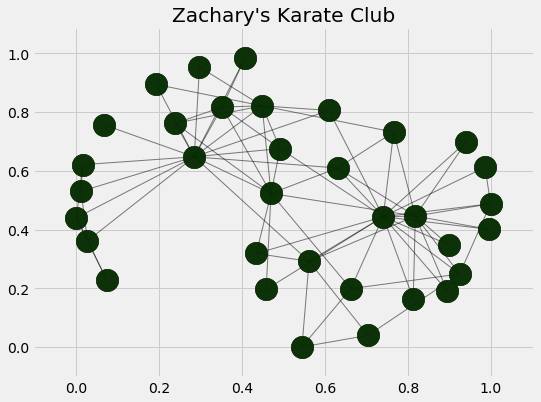

In [111]:
edge_matrix = graph_to_edge_matrix(data)
        
# Position the node using a force-directed algorithm
position = nx.spring_layout(data)
plt.figure(figsize=(8,6)) 
draw_graph(data, to_dict(ground_truth), position)
plt.show()

### K-means Clustering
Identify cluster members such that cluster's mean value converges towards the center

In [93]:
k = 2
results = []
kmeans = cluster.KMeans(n_clusters=k, n_init=200)
kmeans.fit(edge_matrix)

results.append(list(kmeans.labels_))

### Spectral Clustering
Apply clustering to a projection of the normalized Laplacian

In [94]:
spectral = cluster.SpectralClustering(n_clusters=k, affinity="precomputed", n_init=200)
spectral.fit(edge_matrix)

results.append(list(spectral.labels_))

### Agglomerative Clustering
Recursively merge nodes with other clusters while only minimally increasing distance

In [95]:
agglomerative = cluster.AgglomerativeClustering(n_clusters=k, linkage="ward")
agglomerative.fit(edge_matrix)

results.append(list(agglomerative.labels_))

### Affinity Propagation Clustering

Find members that are representative of clusters

In [96]:
affinity = cluster.affinity_propagation(S=edge_matrix, max_iter=200, damping=0.6)

results.append(list(affinity[1]))

### Metrics & Plotting
Normalized Mutual Information measures mutual dependence between two variables (0=dissimilar, 1=perfect match). 

Adjusted Rand Score computes similarity by counting pairs that belong to the same the predicted and true clusters (0=lowest similarity, 1=highest).

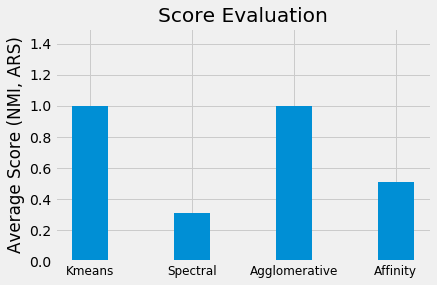

In [112]:
normalized_scores = []
adjusted_scores = []

for result in results:
    normalized_scores.append(normalized_mutual_info_score(ground_truth, result))
    adjusted_scores.append(adjusted_rand_score(ground_truth, result))

average_scores = [sum(score) / 2 for score in zip(normalized_scores, adjusted_scores)]
xlabels = ['Kmeans', 'Spectral', 'Agglomerative', 'Affinity']

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Score Evaluation')
ax.bar(np.arange(len(average_scores)), average_scores, 0.35)

ax.set_ylabel('Average Score (NMI, ARS)')
ax.set_ylim(0, 1.5)


ax.set_xticks(np.arange(len(average_scores)))
xtickNames = ax.set_xticklabels(xlabels)
plt.setp(xtickNames, fontsize=12)
plt.show()

K-means and Agglomerative clustering gave the best results for this dataset. Spectral and Affinity Propagation clustering performed poorly on this data.